In [ ]:
# Adapted from https://openmdao.github.io/dymos/examples/brachistochrone/brachistochrone.html

In [1]:
import numpy as np
import openmdao.api as om

In [30]:
class BrachistochroneExample(om.ExplicitComponent):
    def initialize(self):
        self.options.declare("num_nodes", types=int)

    def setup(self):
        nn = self.options["num_nodes"]

        self.add_input("tf", val=1.0, units="s", tags=["dymos.static_target"])
        # Inputs
        self.add_input("v", val=np.zeros(nn), units="m/s")

        self.add_input("g", val=9.81, units="m/s/s", tags=["dymos.static_target"])

        self.add_input("u", val=np.ones(nn), units="rad")

        self.add_output(
            "xdot",
            val=np.zeros(nn),
            units="m/s",
            tags=["dymos.state_rate_source:x", "dymos.state_units:m"],
        )

        self.add_output(
            "ydot",
            val=np.zeros(nn),
            units="m/s",
            tags=["dymos.state_rate_source:y", "dymos.state_units:m"],
        )

        self.add_output(
            "vdot",
            val=np.zeros(nn),
            units="m/s**2",
            tags=["dymos.state_rate_source:v", "dymos.state_units:m/s"],
        )

        # Setup partials
        r = c = np.arange(self.options["num_nodes"])
        self.declare_partials(of="vdot", wrt="u", rows=r, cols=c)

        self.declare_partials(of="xdot", wrt="v", rows=r, cols=c)
        self.declare_partials(of="xdot", wrt="u", rows=r, cols=c)

        self.declare_partials(of="ydot", wrt="v", rows=r, cols=c)
        self.declare_partials(of="ydot", wrt="u", rows=r, cols=c)

        c_const = np.zeros(self.options["num_nodes"])
        self.declare_partials(of="vdot", wrt="g", rows=r, cols=c_const)

        self.declare_partials(of="vdot", wrt="tf", rows=r, cols=c_const)
        self.declare_partials(of="xdot", wrt="tf", rows=r, cols=c_const)
        self.declare_partials(of="ydot", wrt="tf", rows=r, cols=c_const)

    def compute(self, inputs, outputs):
        u = inputs["u"]
        g = inputs["g"]
        v = inputs["v"]
        tf = inputs["tf"]

        outputs["xdot"] = v * np.sin(u) * tf
        outputs["ydot"] = -v * np.cos(u) * tf
        outputs["vdot"] = g * np.cos(u) * tf

    def compute_partials(self, inputs, partials):
        u = inputs["u"]
        g = inputs["g"]
        v = inputs["v"]
        tf = inputs["tf"]

        partials["xdot", "v"] = np.sin(u) * tf
        partials["xdot", "u"] = v * np.cos(u) * tf
        partials["xdot", "tf"] = v * np.sin(u)

        partials["ydot", "v"] = -np.cos(u) * tf
        partials["ydot", "u"] = v * np.sin(u) * tf
        partials["ydot", "tf"] = -v * np.cos(u)

        partials["vdot", "g"] = np.cos(u) * tf
        partials["vdot", "u"] = -g * np.sin(u) * tf
        partials["vdot", "tf"] = g * np.cos(u)


In [31]:
num_nodes = 5

p = om.Problem(model=om.Group())

ivc = p.model.add_subsystem('vars', om.IndepVarComp())
ivc.add_output('v', shape=(num_nodes,), units='m/s')
ivc.add_output('u', shape=(num_nodes,), units='deg')

p.model.add_subsystem('ode', BrachistochroneExample(num_nodes=num_nodes))

p.model.connect('vars.v', 'ode.v')
p.model.connect('vars.u', 'ode.u')

p.setup(force_alloc_complex=True)

p.set_val('vars.v', 10*np.random.random(num_nodes))
p.set_val('vars.u', 10*np.random.uniform(1, 179, num_nodes))

p.run_model()
cpd = p.check_partials(method='cs', compact_print=True)

---------------------------------------
Component: BrachistochroneExample 'ode'
---------------------------------------

'<output>' wrt '<variable>' | calc mag.  | check mag. | a(cal-chk) | r(cal-chk)
-------------------------------------------------------------------------------

'vdot'     wrt 'g'          | 2.0024e+00 | 2.0024e+00 | 1.5701e-16 | 7.8409e-17
'vdot'     wrt 'tf'         | 1.9644e+01 | 1.9644e+01 | 1.7764e-15 | 9.0428e-17
'vdot'     wrt 'u'          | 9.7620e+00 | 9.7620e+00 | 1.0878e-15 | 1.1143e-16
'vdot'     wrt 'v'          | 0.0000e+00 | 0.0000e+00 | 0.0000e+00 | nan
'xdot'     wrt 'g'          | 0.0000e+00 | 0.0000e+00 | 0.0000e+00 | nan
'xdot'     wrt 'tf'         | 5.6642e+00 | 5.6642e+00 | 3.1402e-16 | 5.5439e-17
'xdot'     wrt 'u'          | 1.3610e+01 | 1.3610e+01 | 8.8818e-16 | 6.5258e-17
'xdot'     wrt 'v'          | 9.9511e-01 | 9.9511e-01 | 2.7756e-17 | 2.7892e-17
'ydot'     wrt 'g'          | 0.0000e+00 | 0.0000e+00 | 0.0000e+00 | nan
'ydot'     wrt 'tf'

In [54]:
import openmdao.api as om
import dymos as dm
from dymos.examples.plotting import plot_results
import matplotlib.pyplot as plt

#
# Initialize the Problem and the optimization driver
#
p = om.Problem(model=om.Group())
p.driver = om.ScipyOptimizeDriver()
p.driver.declare_coloring()

#
# Create a trajectory and add a phase to it
#
traj = p.model.add_subsystem("traj", dm.Trajectory())

phase = traj.add_phase(
    "phase0",
    dm.Phase(
        ode_class=BrachistochroneExample, transcription=dm.GaussLobatto(num_segments=25)
    ),
)

# Set variable options
phase.set_time_options(fix_initial=True, fix_duration=True, duration_bounds=(0.1, 10.0))

phase.add_state("x", fix_initial=True, fix_final=True)
phase.add_state("y", fix_initial=True, fix_final=True)
phase.add_state("v", fix_initial=True, fix_final=False)

phase.add_control(
    "u", continuity=True, rate_continuity=True, units="deg", lower=0.00, upper=360.0
)

phase.add_parameter("g", units="m/s**2", val=9.81)
phase.add_parameter("tf", units="s", val=1.0, opt=True, lower=0.01, upper=2.0)

# Minimize final time
phase.add_objective("tf")

p.model.linear_solver = om.DirectSolver()

#
# Setup the Problem
#
p.setup()
#
# Set the initial values
#
p["traj.phase0.t_initial"] = 0.0
p["traj.phase0.t_duration"] = 1.0

p.set_val("traj.phase0.states:x", phase.interp("x", ys=[0, 2]))
p.set_val("traj.phase0.states:y", phase.interp("y", ys=[0, -2]))
p.set_val("traj.phase0.states:v", phase.interp("v", ys=[0, 9.9]))
p.set_val("traj.phase0.controls:u", phase.interp("u", ys=[0.0, 2 * np.pi]))

#
# Solve for the optimal trajectory
#
dm.run_problem(p)

# Check the results
print("tf = ", p.get_val("traj.phase0.timeseries.parameters:tf")[-1])
# print(p.get_val('traj.phase0.timeseries.time')[-1])



--- Constraint Report [traj] ---
    --- phase0 ---
        None

Model viewer data has already been recorded for Driver.
Full total jacobian was computed 3 times, taking 0.070262 seconds.
Total jacobian shape: (100, 125) 


Jacobian shape: (100, 125)  ( 8.22% nonzero)
FWD solves: 14   REV solves: 0
Total colors vs. total size: 14 vs 125  (88.8% improvement)

Sparsity computed using tolerance: 1e-25
Time to compute sparsity: 0.070262 sec.
Time to compute coloring: 0.058058 sec.
Memory to compute coloring: 0.000000 MB.
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.8256735253364696
            Iterations: 6
            Function evaluations: 6
            Gradient evaluations: 6
Optimization Complete
-----------------------------------
tf =  [0.82567353]


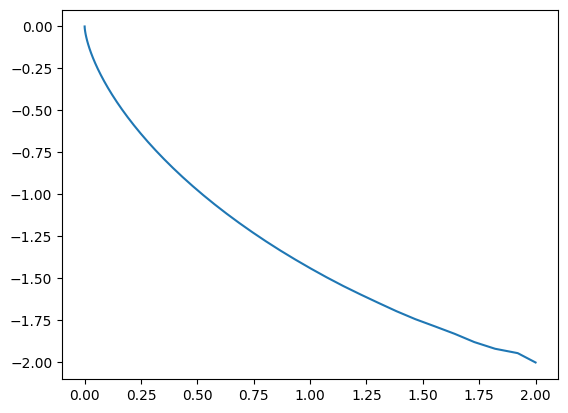

In [55]:
x = [i[0] for i in p.get_val('traj.phase0.timeseries.states:x')]
y = [i[0] for i in p.get_val('traj.phase0.timeseries.states:y')]
plt.plot(x, y)